In [1]:
import torch

import triton
import triton.language as tl

In [9]:
@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr
):
    pid = tl.program_id(axis=0)

    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    tl.store(output_ptr + offsets, output, mask=mask)

In [10]:
def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    n_elements = output.numel()

    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=2048)

    return output

In [11]:
torch.manual_seed(0)
size = 98432

x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)

CompilationError: at 12:33:def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr
):
    pid = tl.program_id(axis=0)

    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    tl.device_print(tl.arange(0, BLOCK_SIZE))
                                 ^
AssertionError('int32[constexpr[2048]] is not string')

In [5]:
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

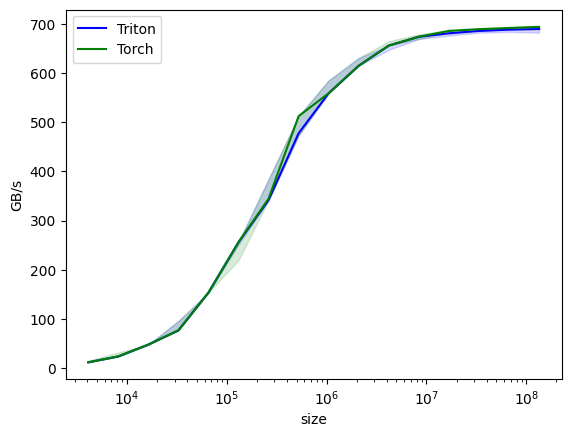

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   76.800002
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  255.999991
6      262144.0  341.333321  344.322252
7      524288.0  477.203890  511.999982
8     1048576.0  558.545450  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  655.359969  655.359969
11    8388608.0  673.315042  673.315042
12   16777216.0  680.304525  685.045290
13   33554432.0  685.045290  688.644505
14   67108864.0  687.712945  691.064996
15  134217728.0  688.946147  693.349742


In [7]:
benchmark.run(print_data=True, show_plots=True)